In [ ]:
'''
-Lite work in progress kring att öppna och analysera tweets.
-Notebooken måste ligga i samma mapp som all data. 
-Rekommenderar att inte köra alla celler, kan nog ta ett tag
 när vi börjar få ihop mer data.
'''

In [24]:
#installera pandas och matplotlib, 
# och numpy om den inte kommer automatiskt med pandas
import json
import glob
import os
import re
import pandas as pd
import numpy as np
import time

In [2]:
#Printar lite extra grejs som kan vara intressant om saker går fel
DEBUG = False

In [3]:
#Genererar ett filträd. Måste ligga i samma mapp som datamapparna
# tree[date][industry][company][handle] är en lista med alla filer för den användaren (alltså: mentions, till, från).  

#TESTAD 19/3, Patrik har kontrollerat att längden på fillistan stämmer överrens med antal jsonfiler och att filnamn
# inte förekommer dubbelt. Koden är testad när notebooken ligger i samma mapp som två datamappar (2020-03-18, 2020-03-19).


tree = {}
INDUSTRIES = ["Airlines"]

#Lista med alla mappar i working directory som heter något i stil med 1111-11-11
collections = [d for d in glob.glob("*") if re.fullmatch(r'[0-9]{4}-[0-9]{2}-[0-9]{2}', d)]

for col in collections:
    tree[col] = {}
    for ind in INDUSTRIES:
        tree[col][ind] = {}
        
        #Den här fångar alla undermappar i /2020-xx-xx/<industry>/
        companies = [os.path.basename(x) for x in glob.glob(os.path.join(col, ind, "*"))]
        
        for comp in companies:
            tree[col][ind][comp] = {}
            
            #Traskar igenom "underfilträdet" för varje företag, alltså med /2020-xx-xx/industry/company/ som root. 
            #Lite snårig men finns bra dokumentation online.
            for root, dirs, files in os.walk(os.path.join(col, ind, comp), topdown=True):
                if dirs:
                    for handle in dirs:
                        tree[col][ind][comp][handle] = []
                else:
                    for f in files:
                        if f.find("tweet") == 0:
                            tree[col][ind][comp][os.path.basename(root)].append(os.path.join(root, f))
                            
#Printar en översikt av hela filträdet
if DEBUG:
    for c in tree.keys():
        print(c)
        for ind in tree[c].keys():
            print('\t', ind)
            for comp in tree[c][ind].keys():
                print('\t\t', comp)
                for handle in tree[c][ind][comp].keys():
                    print('\t\t\t', handle)
                    print('\t\t\t', "antal json:", str(len(tree[c][ind][comp][handle])))
                    for f in tree[c][ind][comp][handle]:
                        print('\t\t\t\t', f)

In [26]:
#Enkel tweeträknare, läser all data så kan ju ta ett tag. 
#Testad för två samlingar (2020-03-18, 2020-03-19)
#OBS, dubbelräknar totalen!
counts = {}
for date in tree.keys():
    counts[date] = {}
    for industry in tree[date].keys():
        for company in tree[date][industry].keys():
            for handle in tree[date][industry][company].keys():
                counts[date][handle] = 0
                for path in tree[date][industry][company][handle]:
                    if DEBUG:
                        print(path)
                    with open(path, 'r') as f:
                        tweet_list = json.loads(f.read())
                    counts[date][handle] += len(tweet_list)
                    
print("Counts: ")
total = 0 #OBS total dubbelräknar tweets om samma tweets finns i olika samlingar. 
for date in counts.keys():
    print(date)
    for handle in counts[date].keys():
        print("\t", handle, counts[date][handle])
        total += counts[date][handle]
print("total:", total)

Counts: 
2020-03-18
	 @AerLingus 19998
	 @aeroflot 4015
	 @airfrance 6623
	 @Alitalia 7368
	 @British_Airways 29000
	 @Finnair 2593
	 @flybe 851
	 @iberia_en 2541
	 @jet2tweets 19019
	 @lufthansa 10307
	 @Fly_Norwegian 7369
	 @flymepegasus 1139
	 @Ryanair 43496
	 @SAS 4551
	 @tapairportugal 8472
	 @TurkishAirlines 7904
	 @vueling 11809
	 @easyJet 39455
	 @agoda 1658
	 @bookingcom 8508
	 @Cheapflights 5
	 @Expedia 20357
	 @ExpediaUK 3610
	 @HomeAwayUK 143
	 @homeaway 1449
	 @HotelTonight 308
	 @HotelTonightCX 168
	 @HotelTonightEU 0
	 @hotelsdotcom 0
	 @Hotwire 1617
	 @KAYAK 220
	 @lastminute_com 5555
	 @OntheBeachUK 2016
	 @Orbitz 1830
	 @priceline 4207
	 @TUIGroup 605
	 @TUIUK 14902
	 @travelocity 2880
	 @trivago 1041
	 @Vrbo 10885
2020-03-19
	 @British_Airways 46619
	 @HotelTonightEU 0
	 @hotelsdotcom 8822
total: 363915


In [ ]:
#Läser in allt i flera DataFrames.
#ITEMS är de fält som tas med. Filtrerar direkt för att spara minne.
#Lite enkla utskrifter för att testa vad som tar tid.
ITEMS = ["created_at", "full_text", "id", "id_str", "metadata", "in_reply_to_status_id", "user", "retweeted_status"]

li = []
t_start = time.time()
for day in tree.keys():
    for company in tree[day]["Airlines"].keys():
        for path in list(tree[day]["Airlines"][company].values())[0]:
            df = pd.read_json(path)
            #Ta bort alla fält som inte finns i items
            df = df.filter(items=ITEMS)
            #Skapa en bool-series baserat på språket och behåll endast kolumner där språket känns igen som engelska.
            en = df.metadata.apply(lambda x: x["iso_language_code"] == "en")
            df = df[en]
            #Lägg till en kolumn som anger vilket företag tweeten insamlats från (alltså EJ avsändaren)
            df["associated_company"]=company
            li.append(df)
            
        
    
print("Time - read files:", time.time()-t_start, "seconds")
data = pd.concat(li)
print("Time - concat:", time.time()-t_start, "seconds")
print("Tweets:", data.shape[0])
print("Memory MB (with duplicates):", data.memory_usage(index=True, deep=True).sum() / 1000000)
data = data.drop_duplicates(subset="id")
print("Tweets (no duplicates):", data.shape[0])
print("Time - drop duplicates:", time.time()-t_start, "seconds")
print("Memory MB (no duplicates):", data.memory_usage(index=True, deep=True).sum() / 1000000)



In [95]:
data.shape

(958, 9)

/home/user/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1104: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


AttributeError: 'AxesSubplot' object has no attribute 'show'

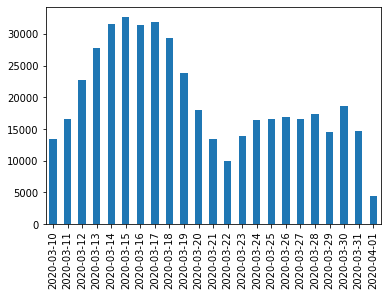

In [74]:
#Exempel på plot av antal tweets per dag. Tror den gör vad jag säger att den gör...
a =data["created_at"].dt.to_period("D").value_counts().sort_index().plot(kind="bar")
b =data["created_at"].dt.to_period("D").value_counts().sort_index().plot(kind="bar")
a.show()

In [82]:
data.shape

(452346, 5)

In [84]:
not_en = data.metadata.apply(lambda x: x["iso_language_code"] != "en")

In [85]:
data[not_en]

,created_at,full_text,id,metadata,associated_company
40,2020-03-18 20:55:19+00:00,@AerLingus https://t.co/sgPZEatA2C https://t.c...,1240381289989095427,"{'iso_language_code': 'und', 'result_type': 'r...",Aer Lingus
51,2020-03-18 20:46:25+00:00,@AerLingus https://t.co/lpfO0vOCa0,1240379048901083136,"{'iso_language_code': 'und', 'result_type': 'r...",Aer Lingus
67,2020-03-18 20:32:44+00:00,@AerLingus #aerlingusdotherightthing https://t...,1240375606434582528,"{'iso_language_code': 'und', 'result_type': 'r...",Aer Lingus
101,2020-03-18 20:08:04+00:00,"eire – load, burden\nÉire – Ireland\n\n@HSELiv...",1240369397904158721,"{'iso_language_code': 'no', 'result_type': 're...",Aer Lingus
144,2020-03-18 19:46:06+00:00,@AerLingus https://t.co/am8HpeAPAt,1240363872827080704,"{'iso_language_code': 'und', 'result_type': 'r...",Aer Lingus
...,...,...,...,...,...
867,2020-03-30 14:22:04+00:00,@joffreylm @maamar69007 @Dazz59 @easyJet Oui,1244630982382280705,"{'iso_language_code': 'und', 'result_type': 'r...",easyJet
875,2020-03-30 14:21:10+00:00,@LFC_Unbearables @scatterbrainjoe @moomskib @e...,1244630754975498246,"{'iso_language_code': 'und', 'result_type': 'r...",easyJet
895,2020-03-30 14:18:55+00:00,@easyJet @lukehughesman1,1244630188689895425,"{'iso_language_code': 'und', 'result_type': 'r...",easyJet
962,2020-03-30 14:11:42+00:00,No obtengo respuesta por teléfono (ni en UK ni...,1244628370245267461,"{'iso_language_code': 'es', 'result_type': 're...",easyJet
